# Kmeans motifs

## Kmeans

### Data

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from katlas.core import *
from katlas.plot import *
import pandas as pd, numpy as np

In [ ]:
# human = pd.read_parquet('raw/human_phosphoproteome.parquet')
# df_grouped = pd.read_parquet('raw/combine_source_grouped.parquet')
human = Data.get_human_site()
df_grouped = Data.get_ks_dataset()

In [ ]:
all_site = pd.concat([human,df_grouped])

In [ ]:
all_site.sub_site.isna().sum()

0

In [ ]:
all_site = all_site.drop_duplicates('sub_site')

In [ ]:
all_site.shape

(131843, 19)

In [ ]:
# all_site = all_site[['sub_site','site_seq']].drop_duplicates('sub_site')

## One-hot encode

In [ ]:
%%time
onehot = onehot_encode(all_site['site_seq'])

CPU times: user 4.16 s, sys: 768 ms, total: 4.93 s
Wall time: 4.93 s


In [ ]:
onehot.head()

-20A  -20C  -20D  -20E  -20F  -20G  -20H  -20I  -20K  -20L  ...  20R  20S  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  1.0  0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   
2   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   
3   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   

   20T  20V  20W  20Y  20_  20s  20t  20y  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 967 columns]

### Elbow method

In [ ]:
all_site.shape

(131843, 19)

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

CPU times: user 23min 20s, sys: 46.3 s, total: 24min 6s
Wall time: 9min 50s


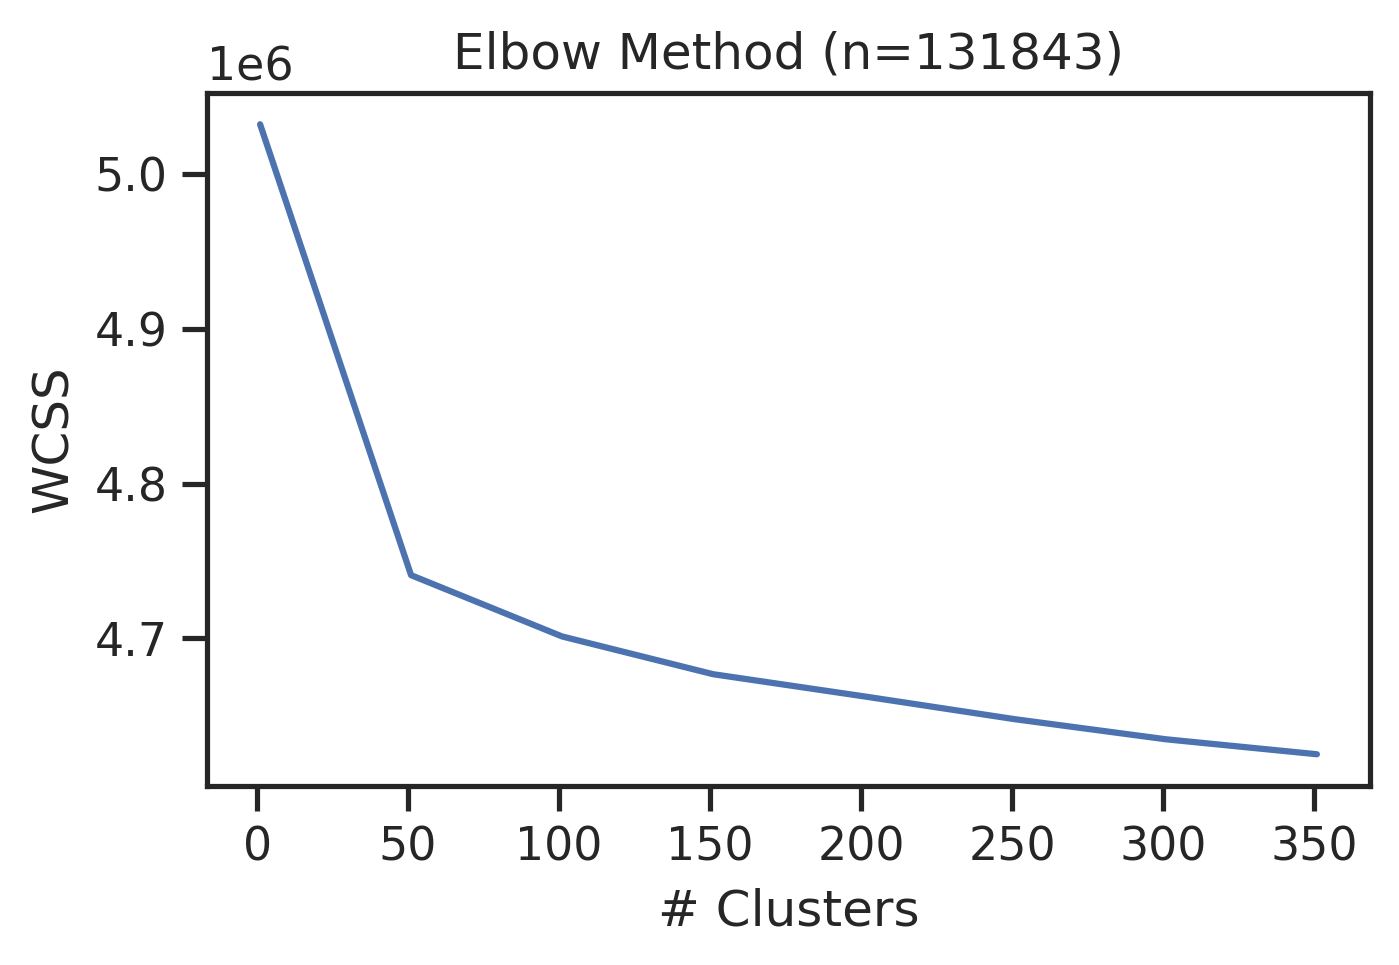

In [ ]:
%%time
get_clusters_elbow(onehot)

### Kmeans

If using RAPIDS

In [ ]:
# # pip install --extra-index-url=https://pypi.nvidia.com \"cudf-cu12==25.2.*\" \"cuml-cu12==25.2.*\"

# %load_ext cudf.pandas

# import numpy as np, pandas as pd
# from cuml import KMeans
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# from katlas.core import *
# from katlas.plot import *

In [ ]:
def kmeans(onehot,n=2,seed=42):
    kmeans = KMeans(n_clusters=n, random_state=seed,n_init='auto')
    return kmeans.fit_predict(onehot)

In [ ]:
ncluster=[50,150,300]
seeds=[42,2025,28]

In [ ]:
all_site['test_id']=1

In [ ]:
get_cluster_pssms(all_site,'test_id')

100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


-20P     -20G     -20A     -20C     -20S     -20T    -20V    -20I  \
1  0.07984  0.06669  0.07291  0.01333  0.06488  0.04065  0.0505  0.0346   

     -20L     -20M  ...      20H      20K      20R      20Q     20N      20D  \
1  0.0812  0.01958  ...  0.02192  0.06782  0.06339  0.04731  0.0334  0.05239   

      20E     20pS     20pT     20pY  
1  0.0798  0.04184  0.01385  0.00508  

[1 rows x 943 columns]

In [ ]:
pssms=[]
for seed in seeds:
    print('seed',seed)
    for n in ncluster:
        colname = f'cluster{n}_seed{seed}'
        print(colname)
        all_site[colname] = kmeans(onehot,n=n,seed=seed)
        pssm_df = get_cluster_pssms(all_site,colname,blank_thr=0.5)
        pssm_df.index =colname+'_'+pssm_df.index.astype(str)
        pssms.append(pssm_df)

seed 42
cluster50_seed42


100%|██████████| 50/50 [00:04<00:00, 11.50it/s]


cluster150_seed42


100%|██████████| 150/150 [00:06<00:00, 23.67it/s]


cluster300_seed42


100%|██████████| 300/300 [00:09<00:00, 32.17it/s]


seed 2025
cluster50_seed2025


100%|██████████| 50/50 [00:04<00:00, 12.48it/s]


cluster150_seed2025


100%|██████████| 150/150 [00:06<00:00, 23.80it/s]


cluster300_seed2025


100%|██████████| 300/300 [00:09<00:00, 32.20it/s]


seed 28
cluster50_seed28


100%|██████████| 50/50 [00:04<00:00, 12.24it/s]


cluster150_seed28


100%|██████████| 150/150 [00:06<00:00, 23.97it/s]


cluster300_seed28


100%|██████████| 300/300 [00:09<00:00, 30.65it/s]


In [ ]:
pssms = pd.concat(pssms,axis=0)

Save:

In [ ]:
# pssms.to_parquet('raw/kmeans.parquet')
# all_site.to_parquet('raw/kmeans_site.parquet',index=False)

In [ ]:
pssms = pd.read_parquet('raw/kmeans.parquet')

all_site=pd.read_parquet('raw/kmeans_site.parquet')

In [ ]:
all_site.head()

substrate_uniprot                substrate_genes site source  \
0        A0A024R4G9  C19orf48 MGC13170 hCG_2008493  S20    psp   
1        A0A075B6Q4                           None  S24  ochoa   
2        A0A075B6Q4                           None  S35  ochoa   
3        A0A075B6Q4                           None  S57  ochoa   
4        A0A075B6Q4                           None  S68  ochoa   

   AM_pathogenicity                                 substrate_sequence  \
0               NaN  MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...   
1               NaN  MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...   
2               NaN  MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...   
3               NaN  MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...   
4               NaN  MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...   

      substrate_species        sub_site  \
0  Homo sapiens (Human)  A0A024R4G9_S20   
1  Homo sapiens (Human)  A0A075B6Q4_S24   
2  Homo sapiens (Human)  A0A075B6Q4_S35   
3  Homo sapiens (Human)  A0A075B6Q4_S57   
4  Homo sapiens (Human)  A0A075B6Q4_S68   

                                substrate_phosphoseq  position  ... test_id  \
0  MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTRTWLLSH...        20  ...       1   
1  MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...        24  ...       1   
2  MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...        35  ...       1   
3  MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...        57  ...       1   
4  MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...        68  ...       1   

  cluster50_seed42 cluster150_seed42  cluster300_seed42 cluster50_seed2025  \
0               33               126                187                 48   
1               41                28                288                 42   
2               45               102                100                 30   
3               30                81                 81                 30   
4               11                75                 68                 10   

  cluster150_seed2025 cluster300_seed2025 cluster50_seed28 cluster150_seed28  \
0                 136                 119                3                45   
1                 117                  28                2               149   
2                 122                 122                6               149   
3                 122                  58               40               110   
4                  48                 164               39                97   

   cluster300_seed28  
0                261  
1                149  
2                149  
3                252  
4                137  

[5 rows x 29 columns]

### Get JS distance

Get 1D distance

In [ ]:
def compute_distance_matrix(df,func):
    "Compute 1D distance matrix for each row in a dataframe given a distance function "
    n = len(df)
    dist = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            d = func(df.iloc[i], df.iloc[j])
            dist.append(d)
    return np.array(dist)

In [ ]:
from tqdm.contrib.concurrent import process_map
from functools import partial
import numpy as np
import pandas as pd

def compute_distance(pair, df, func):
    i, j = pair
    return func(df.iloc[i], df.iloc[j])

def compute_distance_matrix_parallel(df, func, max_workers=4, chunksize=100):
    n = len(data)
    index_pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]

    # Create a wrapper for partial application
    bound_worker = partial(compute_distance, data=df, func=func)

    dist = process_map(bound_worker, index_pairs, max_workers=max_workers, chunksize=chunksize)
    return np.array(dist)

In [ ]:
from fastcore.meta import delegates
from functools import partial
from tqdm.contrib.concurrent import process_map

In [ ]:
def compute_distance_matrix_parallel(df, func, max_workers=4, chunksize=100):
    n = len(df)
    index_pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]

    bound_worker = partial(compute_distance, df=df, func=func)

    dist = process_map(bound_worker, index_pairs, max_workers=max_workers, chunksize=chunksize)
    return np.array(dist)

In [ ]:
@delegates(compute_distance_matrix_parallel)
def compute_JS_matrix_parallel(df, func=js_divergence_flat, **kwargs): 
    "Compute 1D distance matrix using JS divergence."
    return compute_distance_matrix_parallel(df, func=func, **kwargs)

In [ ]:
pssms[pssms.index.str.contains('cluster0')]

Empty DataFrame
Columns: [-20P, -20G, -20A, -20C, -20S, -20T, -20V, -20I, -20L, -20M, -20F, -20Y, -20W, -20H, -20K, -20R, -20Q, -20N, -20D, -20E, -20pS, -20pT, -20pY, -19P, -19G, -19A, -19C, -19S, -19T, -19V, -19I, -19L, -19M, -19F, -19Y, -19W, -19H, -19K, -19R, -19Q, -19N, -19D, -19E, -19pS, -19pT, -19pY, -18P, -18G, -18A, -18C, -18S, -18T, -18V, -18I, -18L, -18M, -18F, -18Y, -18W, -18H, -18K, -18R, -18Q, -18N, -18D, -18E, -18pS, -18pT, -18pY, -17P, -17G, -17A, -17C, -17S, -17T, -17V, -17I, -17L, -17M, -17F, -17Y, -17W, -17H, -17K, -17R, -17Q, -17N, -17D, -17E, -17pS, -17pT, -17pY, -16P, -16G, -16A, -16C, -16S, -16T, -16V, -16I, ...]
Index: []

[0 rows x 943 columns]

In [ ]:
distances = compute_JS_matrix_parallel(pssms,max_workers=32)

  0%|          | 0/1066530 [00:00<?, ?it/s]

In [ ]:
distances

array([0.02719099, 0.02964083, 0.03350885, ..., 0.23451136, 0.32064881,
       0.29473009])

### Hierarchical clustering

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram

In [ ]:
Z = linkage(distances, method='ward')

In [ ]:
def plot_dendrogram(Z,output='dendrogram.pdf',color_thr=0.03,**kwargs):
    length=(len(Z)+1)//8
    
    plt.figure(figsize=(5,length))
    dendrogram(Z, orientation='left', leaf_font_size=7, color_threshold=color_thr,**kwargs)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('Distance')
    plt.savefig(output, bbox_inches='tight')
    plt.close()

In [ ]:
labels = [i+': '+pssm_to_seq(recover_pssm(r),0.2) for i,r in pssms.iterrows()]

In [ ]:
labels[:5]

['cluster50_seed42_28: ....................t*....................',
 'cluster50_seed42_2: ....................y*....................',
 'cluster50_seed42_31: ....................y*....................',
 'cluster50_seed42_10: ..................sPt*.s..................',
 'cluster50_seed42_9: ....................s*....................']

In [ ]:
# plot_dendrogram(Z,output='raw/dendrogram1.pdf',labels=labels)

Visualize and find out the color threshold that works. 

After determine the color threshold, use it to cut the tree.

Visualize some logos

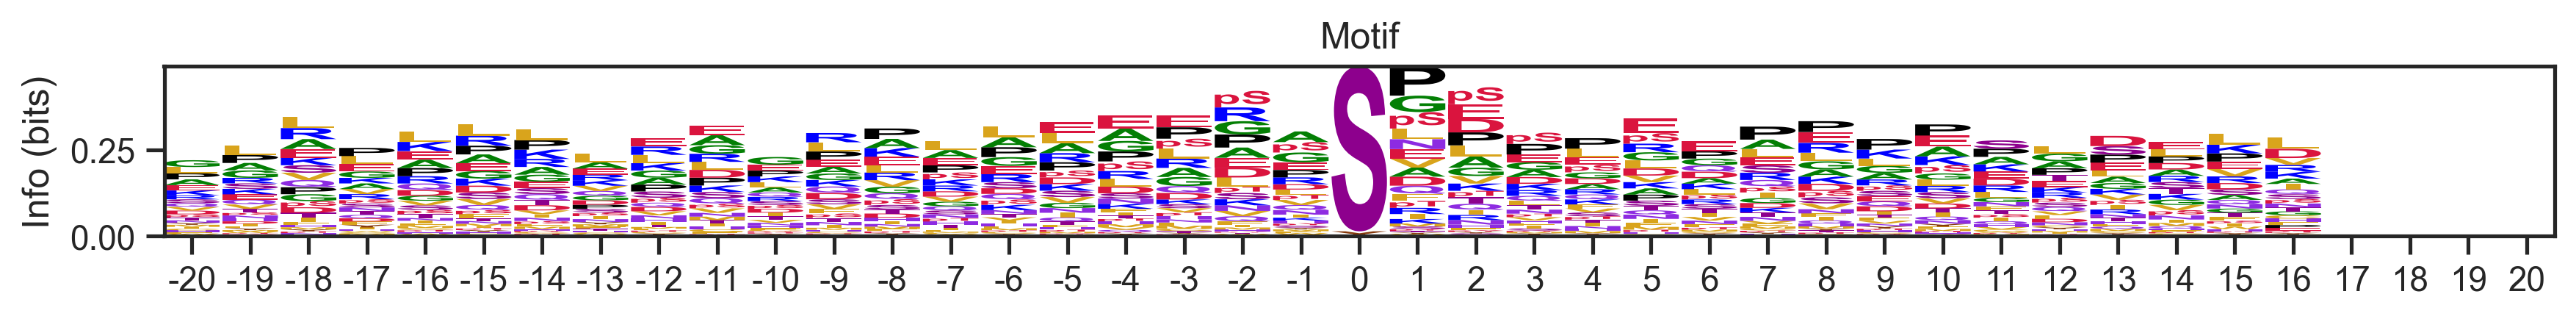

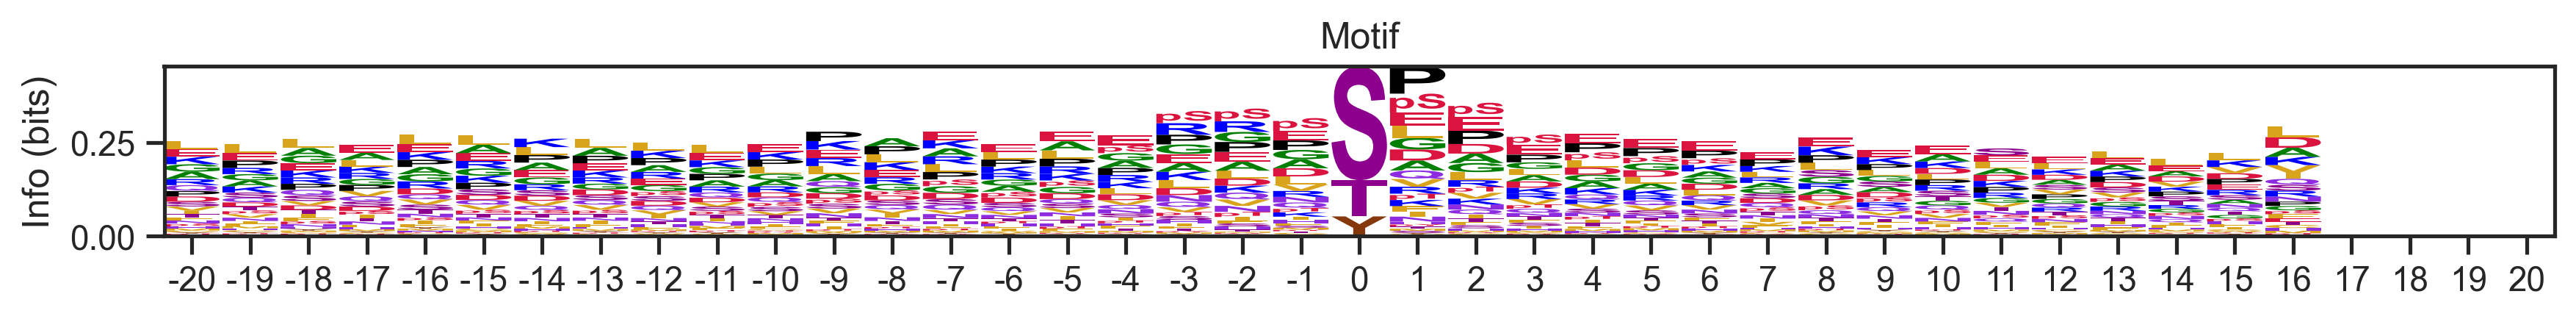

In [ ]:
plot_logos(pssms, 'cluster300_seed28_217','cluster50_seed42_40')

### Cut trees

In [ ]:
labels = fcluster(Z, t=0.03, criterion='distance')
# pssm_df['cluster'] = labels

In [ ]:
Z.shape

(1460, 4)

In [ ]:
len(labels)

1461

In [ ]:
np.unique(labels)[:10] # always start from 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

###  Expand the cluster into a single column

In [ ]:
id_vars = ['sub_site', 'site_seq']
value_vars = [col for col in all_site.columns if col.startswith('cluster')]

In [ ]:
all_site_long = pd.melt(all_site, id_vars=id_vars, value_vars=value_vars, var_name='cluster_info', value_name='cluster')

In [ ]:
all_site_long['cluster_id']=all_site_long['cluster_info'] + '_' + all_site_long['cluster'].astype(str)

In [ ]:
all_site_long.head()

sub_site                                   site_seq  \
0  A0A024R4G9_S20  _MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTR   
1  A0A075B6Q4_S24  QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPG   
2  A0A075B6Q4_S35  EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKTHRAIADHLF   
3  A0A075B6Q4_S57  EDCMSVPGKTHRAIADHLFWsEETKSRFTEYsMTssVMRRN   
4  A0A075B6Q4_S68  RAIADHLFWsEETKSRFTEYsMTssVMRRNEQLTLHDERFE   

       cluster_info  cluster           cluster_id  
0  cluster50_seed42       33  cluster50_seed42_33  
1  cluster50_seed42       41  cluster50_seed42_41  
2  cluster50_seed42       45  cluster50_seed42_45  
3  cluster50_seed42       30  cluster50_seed42_30  
4  cluster50_seed42       11  cluster50_seed42_11

In [ ]:
# all_site_long.to_parquet('raw/kmeans_site_long.parquet',index=False)

### Map new cluster

In [ ]:
len(labels)

1461

In [ ]:
cluster_map = pd.Series(labels,index=pssms.index)

In [ ]:
cluster_map.sort_values()

cluster150_seed2025_55       1
cluster300_seed28_117        1
cluster150_seed28_117        1
cluster300_seed2025_293      1
cluster300_seed28_28         2
                          ... 
cluster150_seed2025_67     747
cluster300_seed2025_9      747
cluster300_seed28_115      747
cluster300_seed2025_278    748
cluster300_seed42_44       748
Length: 1461, dtype: int32

For those unmapped cluster_ID, we assign them zero value:

In [ ]:
# not all cluster_id have a corresponding for new cluster ID, as they could be filtered out
all_site_long['cluster_new'] = all_site_long.cluster_id.map(lambda x: cluster_map.get(x, 0)) #0 is unmapped

In [ ]:
# all_site_long.to_parquet('raw/kmeans_site_long_cluster_new.parquet',index=False)

### Get new cluster motifs

In [ ]:
get_cluster_pssms?

Signature:
get_cluster_pssms(
    df,
    cluster_col,
    seq_col='site_seq',
    id_col='sub_site',
    count_thr=10,
    valid_thr=None,
    plot=False,
)
Docstring: Extract motifs from clusters in a dataframe
File:      /tmp/ipykernel_2927/3575038003.py
Type:      function

In [ ]:
get_cluster_pssms?

Signature:
get_cluster_pssms(
    df,
    cluster_col,
    seq_col='site_seq',
    id_col='sub_site',
    count_thr=10,
    valid_thr=None,
    plot=False,
)
Docstring: Extract motifs from clusters in a dataframe
File:      /tmp/ipykernel_2927/1868936855.py
Type:      function

In [ ]:
pssms2 = get_cluster_pssms(all_site_long,
                           'cluster_new',
                           count_thr=10,
                           blank_thr=0.3)

100%|██████████| 749/749 [00:22<00:00, 33.07it/s]


In [ ]:
pssms2.shape

(749, 943)

In [ ]:
pssms2 = pssms2.drop(index=0) # as 0 represents unmapped

In [ ]:
pssms2.sort_index().to_parquet('out/all_site_pssms.parquet')

In [ ]:
distances = compute_JS_matrix_parallel(pssms2)
Z = linkage(distances, method='ward')

  0%|          | 0/279378 [00:00<?, ?it/s]

In [ ]:
all_site_long.cluster_new

0          447
1          349
2          277
3          396
4          365
          ... 
1186582    664
1186583    541
1186584    660
1186585    679
1186586    676
Name: cluster_new, Length: 1186587, dtype: int64

In [ ]:
count_map = all_site_long.drop_duplicates(subset=["cluster_new","sub_site"])["cluster_new"].value_counts()

In [ ]:
count_map

cluster_new
548    10755
676    10570
689     9921
577     8877
655     8153
       ...  
4         96
260       91
18        82
724       73
261       67
Name: count, Length: 749, dtype: int64

In [ ]:
def pssm_to_seq(pssm_df, 
                thr=0.4, # threshold of probability to show in sequence
                clean_center=True, # if true, zero out non-last three values in position 0 (keep only s,t,y values at center)
                ):
    "Represent PSSM in string sequence of amino acids"
    
    pssm_df = pssm_df.copy()
    if clean_center:
        pssm_df.loc[pssm_df.index[:-3], 0] = 0  # keep only s,t,y in center 0 position

    pssm_df.index = pssm_df.index.map(lambda x: x.replace('pS', 's').replace('pT', 't').replace('pY', 'y'))

    consensus = []
    for i, col in enumerate(pssm_df.columns):
        # consider the case where sum for the position is 0
        column_vals = pssm_df[col]
        if column_vals.sum() == 0:
            symbol = '_'
        else:
            top = column_vals.nlargest(3)
            passing = [aa for aa, prob in zip(top.index, top.values) if prob > thr]

            if not passing:
                symbol = '.'
            elif len(passing) == 1:
                symbol = passing[0]
            else:
                symbol = f"[{'/'.join(passing)}]"
                
        if col == 0:  # center position
            if symbol.startswith('['):
                symbol = symbol[:-1] + ']*'
            else:
                symbol += '*'

        consensus.append(symbol)

    return ''.join(consensus)

In [ ]:
labels=[str(i)+f' (n={count_map[i]:,})' + ': '+pssm_to_seq(recover_pssm(r),0.2) for i,r in pssms2.iterrows()]

In [ ]:
labels[:4]

['548 (n=10,755): ....................s*....................',
 '676 (n=10,570): ....................y*....................',
 '689 (n=9,921): ....................t*....................',
 '577 (n=8,877): ....................s*P...................']

In [ ]:
def plot_dendrogram(Z,output='dendrogram.pdf',color_thr=0.03,**kwargs):
    length=(len(Z)+1)//7
    
    plt.figure(figsize=(5,length))
    dendrogram(Z, orientation='left', leaf_font_size=7, color_threshold=color_thr,**kwargs)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('Distance')
    plt.savefig(output, bbox_inches='tight')
    plt.close()

In [ ]:
plot_dendrogram(Z,output='out/dendrogram_label2.pdf',labels=labels,color_thr=0.07)

## Onehot of cluster number

In [ ]:
all_site_long['sub_site_seq'] = all_site_long['sub_site']+'_'+all_site_long['site_seq']

In [ ]:
all_site_onehot = pd.crosstab(all_site_long['sub_site_seq'], all_site_long['cluster_new'])

In [ ]:
# greater than 0 to be True and convert to int
all_site_onehot = all_site_onehot.gt(0).astype(int)

In [ ]:
all_site_onehot.max()

cluster_new
1      1
2      1
3      1
4      1
5      1
      ..
744    1
745    1
746    1
747    1
748    1
Length: 748, dtype: int64

In [ ]:
# remove 0 as it is unassigned for cut tree
all_site_onehot = all_site_onehot.drop(columns=0)

In [ ]:
all_site_onehot.columns

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       739, 740, 741, 742, 743, 744, 745, 746, 747, 748],
      dtype='int64', name='cluster_new', length=748)

In [ ]:
all_site_onehot.sum().sort_values()

cluster_new
261       67
724       73
18        82
260       91
4         96
       ...  
655     8153
577     8877
689     9921
676    10570
548    10755
Length: 748, dtype: int64

In [ ]:
# all_site_onehot.to_parquet('out/all_site_cluster_onehot.parquet')

## Special motifs

In [ ]:
def plot_logos(pssms_df,*idxs):
    "Plot logos of a dataframe with flattened PSSMs with index ad IDs."
    for idx in idxs:
        pssm = recover_pssm(pssms_df.loc[idx])
        plot_logo(pssm,title=f'Motif {idx}',figsize=(14,1))
        plt.show()
        plt.close()

### Customized

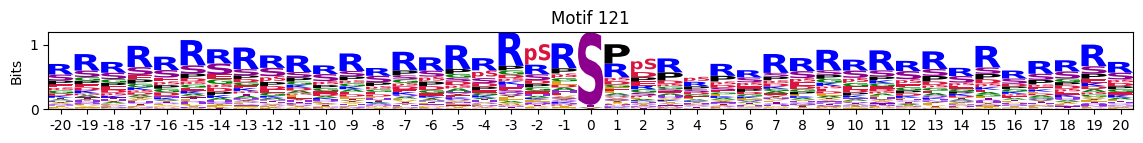

In [ ]:
plot_logos(pssms2,121)

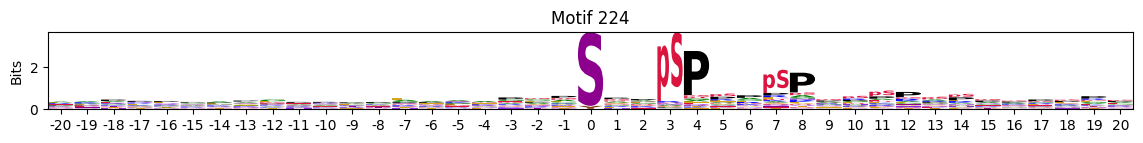

In [ ]:
plot_logos(pssms2,224)

### Most common

In [ ]:
idxs = all_site_onehot.sum().sort_values(ascending=False).head(20).index

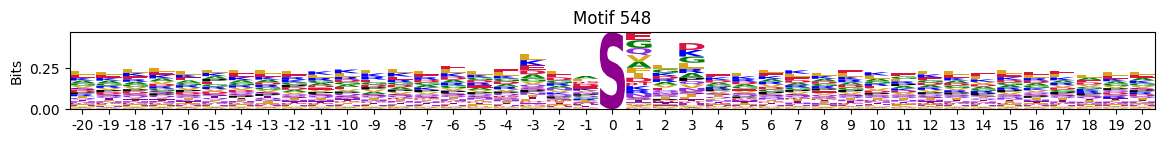

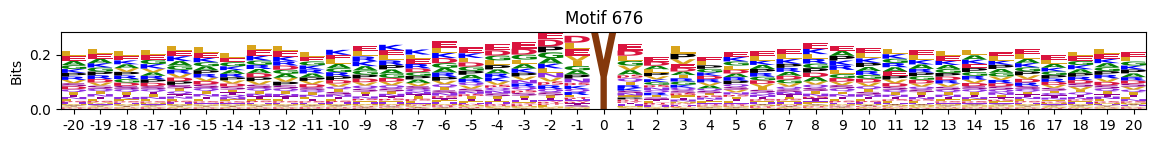

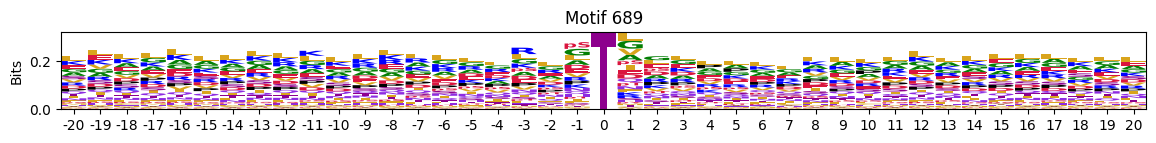

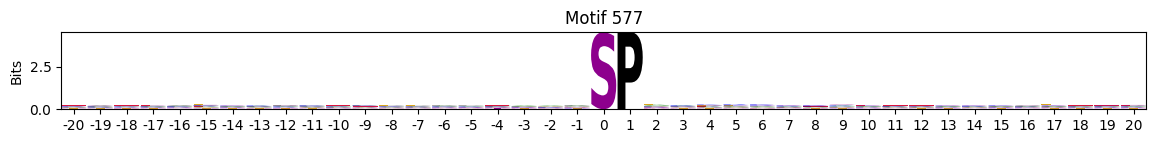

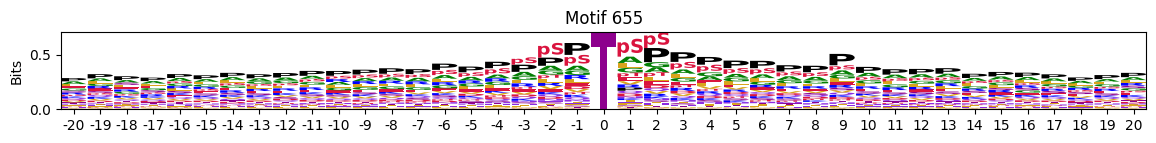

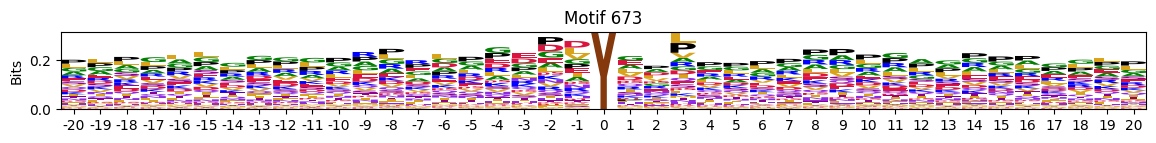

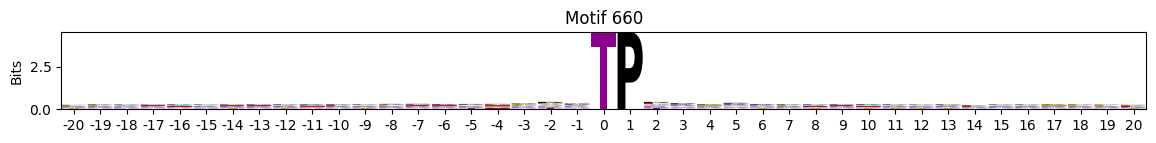

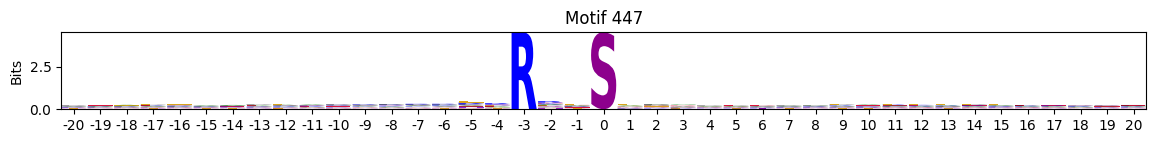

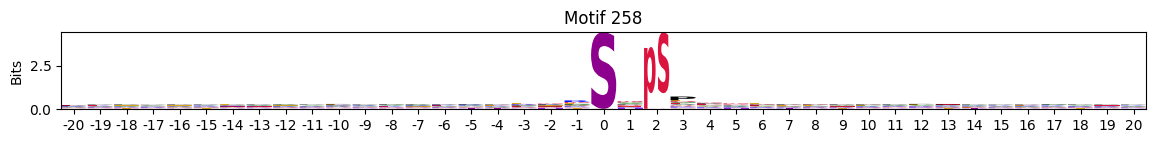

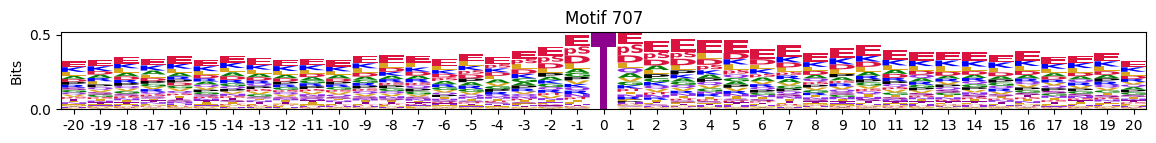

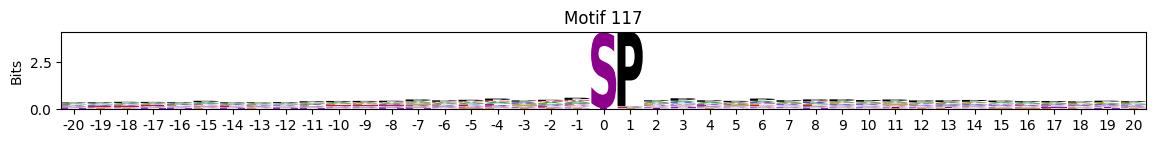

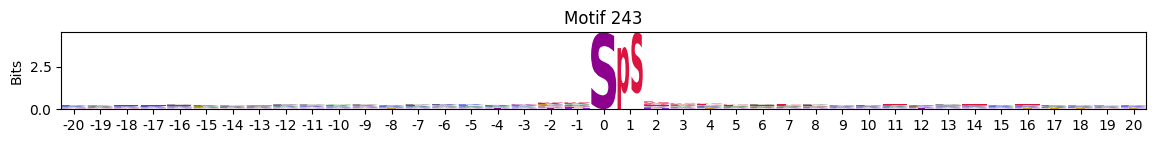

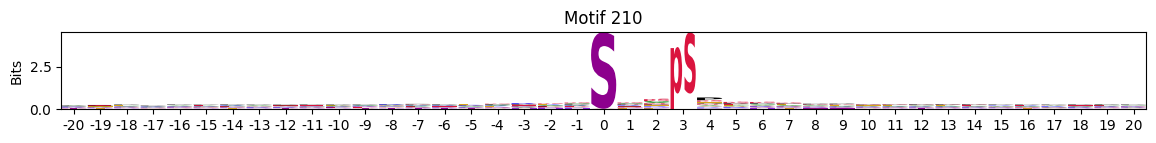

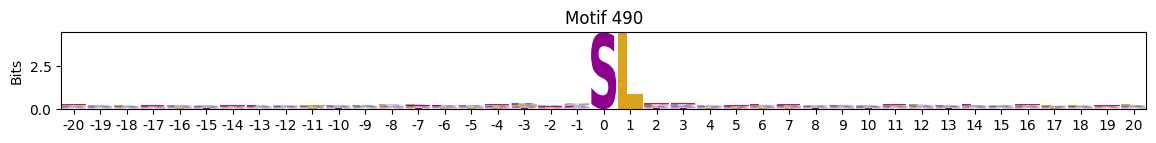

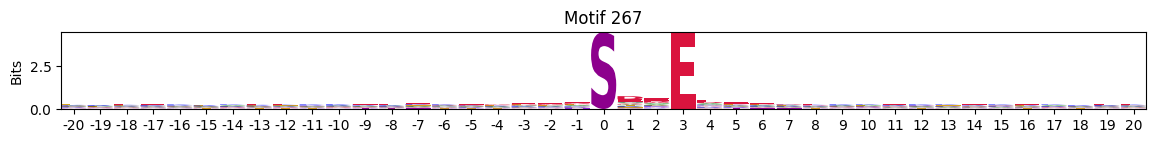

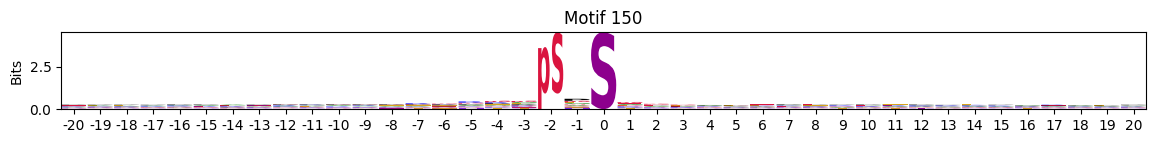

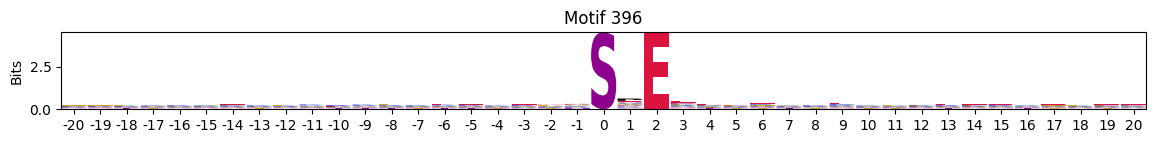

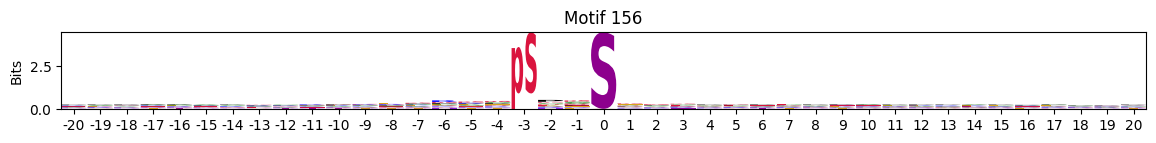

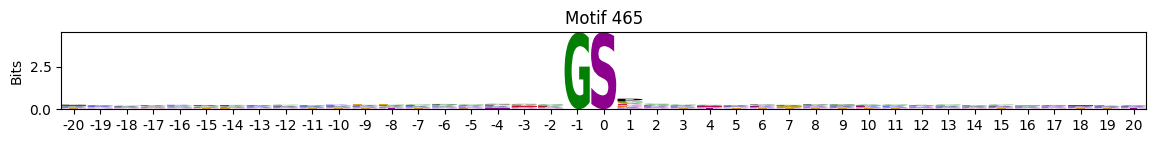

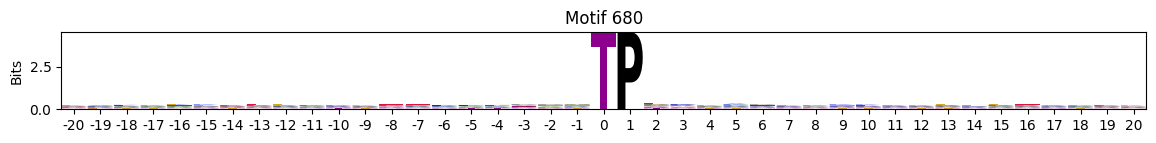

In [ ]:
plot_logos(pssms2, *idxs)

### Entropy per position

In [ ]:
pssms2_entropy = pssms2.apply(lambda r: entropy_flat(r),axis=1)

In [ ]:
# remove 0 and focus on those neighboring residues
pssms2_entropy = pssms2_entropy.drop(columns=0)

In [ ]:
idxs=pssms2_entropy.min(1).sort_values().head(10).index

Motif with lowest entropies:

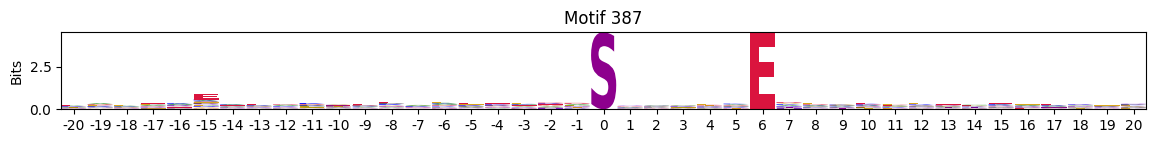

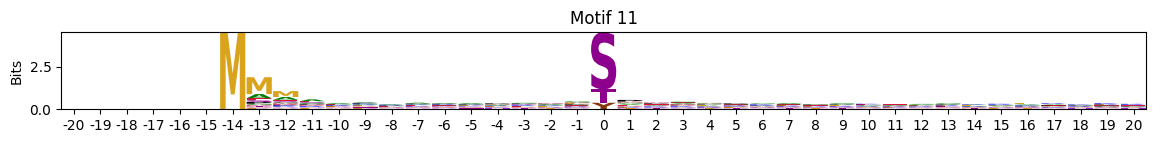

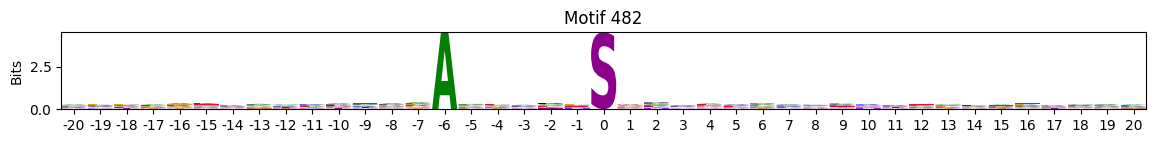

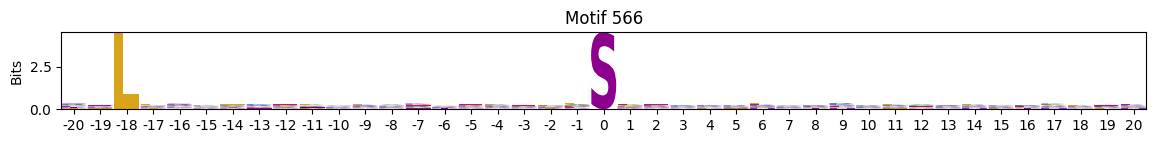

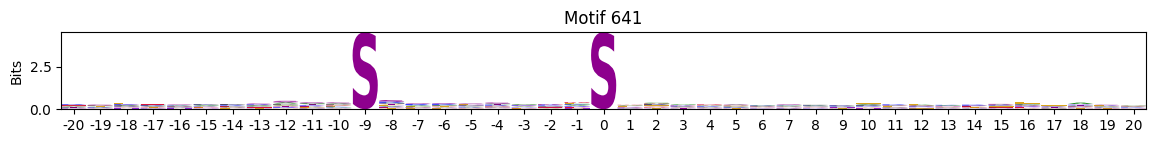

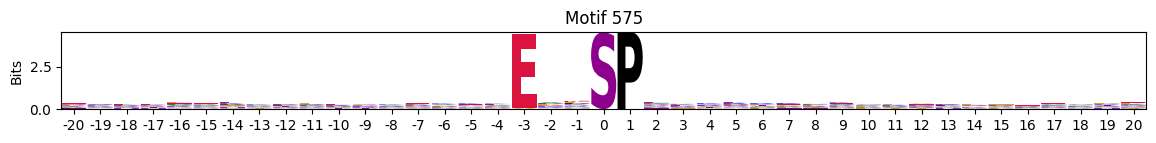

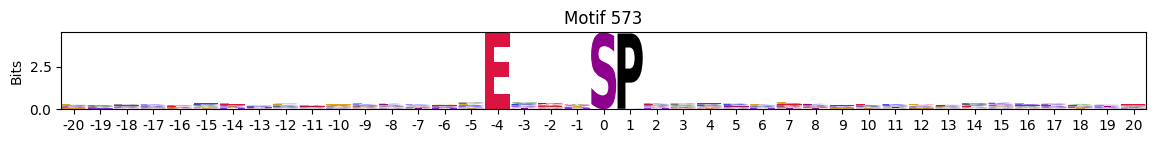

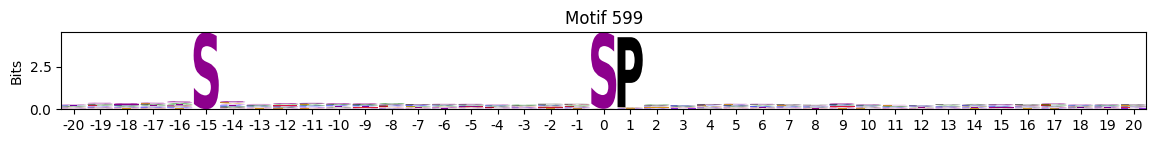

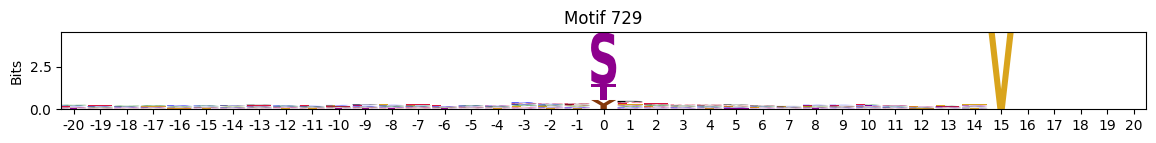

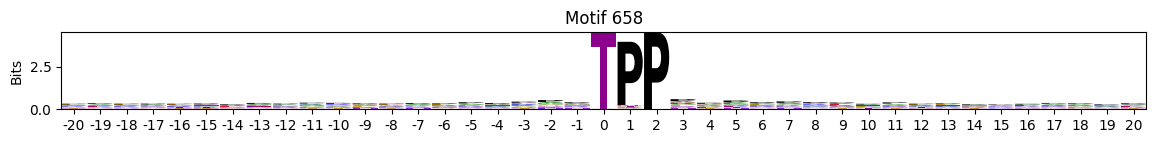

In [ ]:
plot_logos(pssms2,*idxs)

### Low median entropy

Motifs with low median entropies:

In [ ]:
idxs=pssms2_entropy.median(1).sort_values().head(10).index

The first one is mostly Zinc finger protein

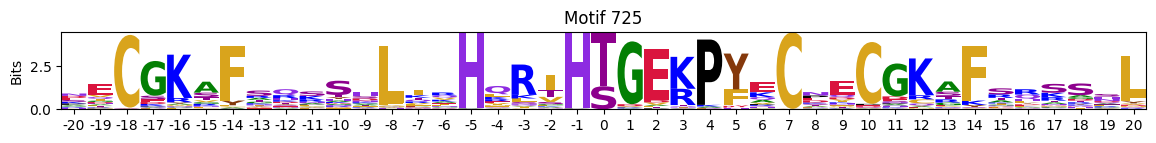

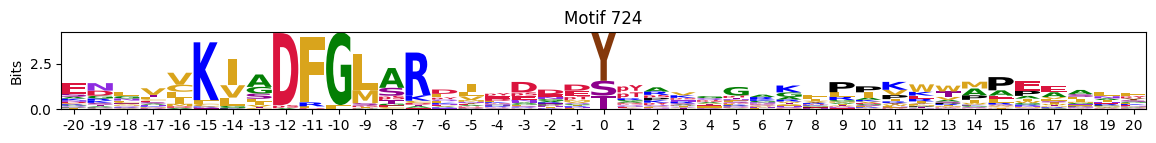

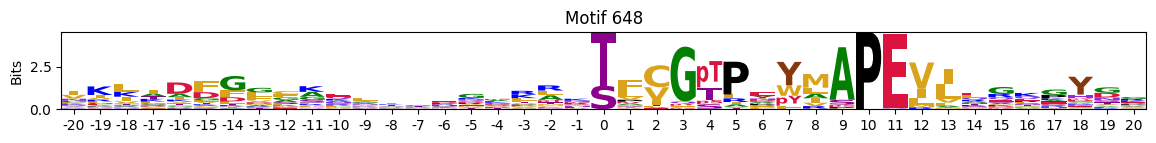

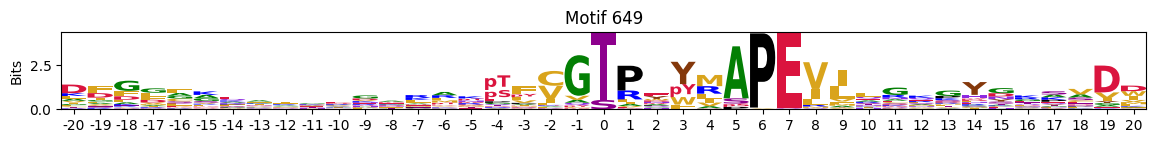

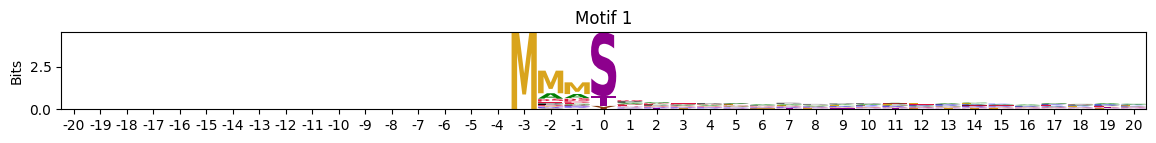

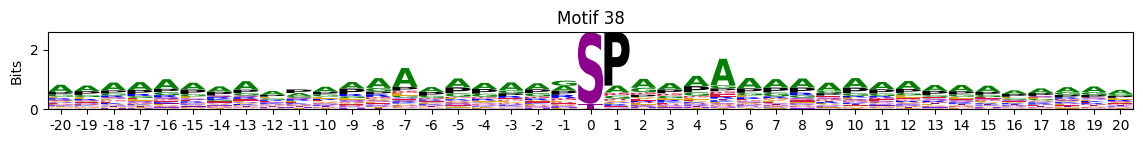

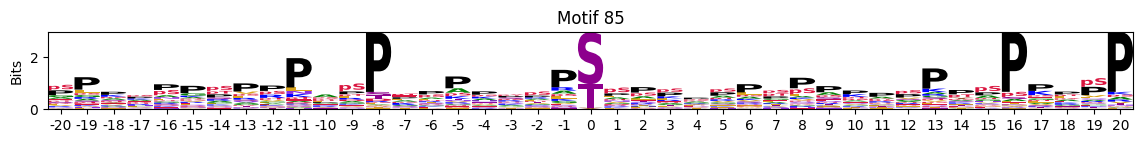

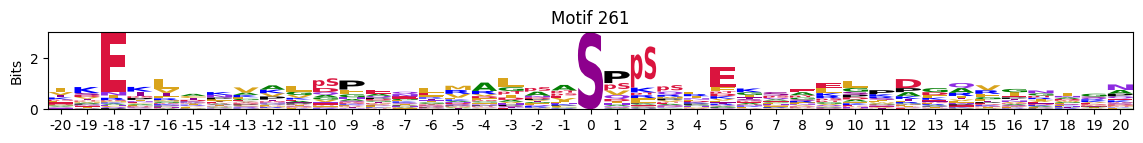

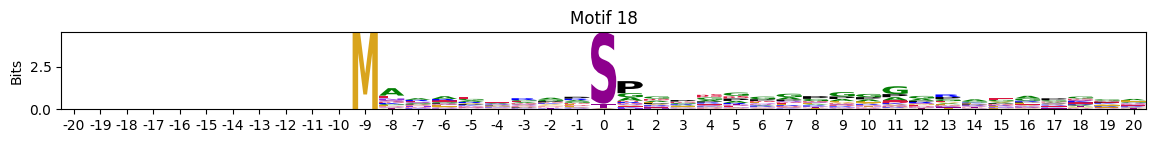

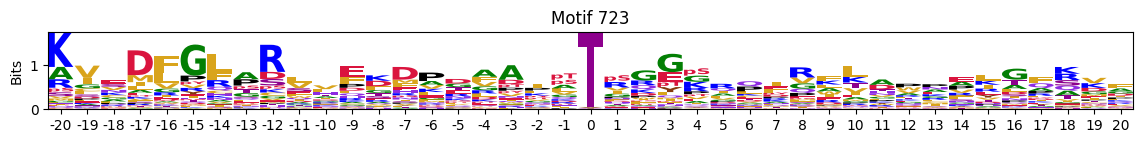

In [ ]:
plot_logos(pssms2,*idxs)

In [ ]:
idxs=pssms2_entropy.sum(1).sort_values().head(10).index

In [ ]:
idxs=(pssms2==0).sum(1).sort_values(ascending=False).index

### C-terminal motifs

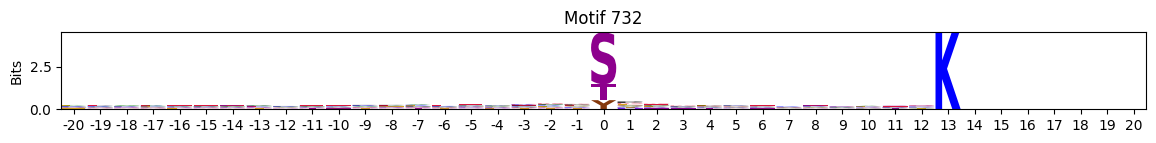

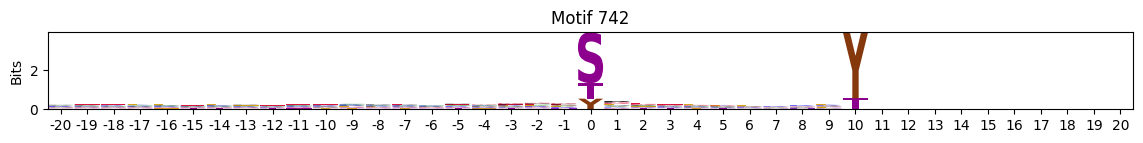

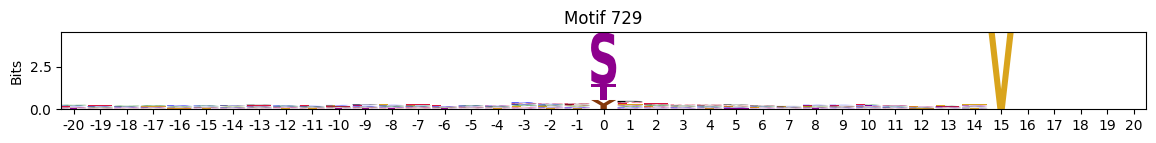

In [ ]:
plot_logos(pssms2,732,742,729)

In [ ]:
zeros_right = pssms2.apply(lambda r: (recover_pssm(r).loc[:,1:].sum()==0).sum() , axis=1)

In [ ]:
idxs = zeros_right.sort_values(ascending=False).head(10).index

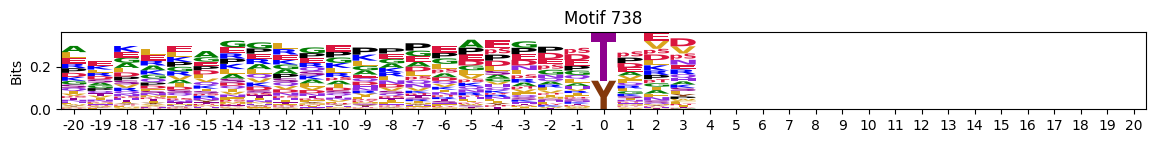

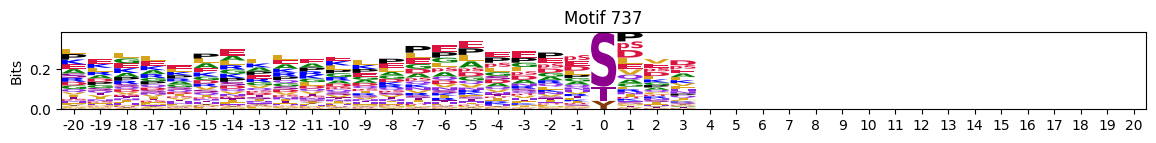

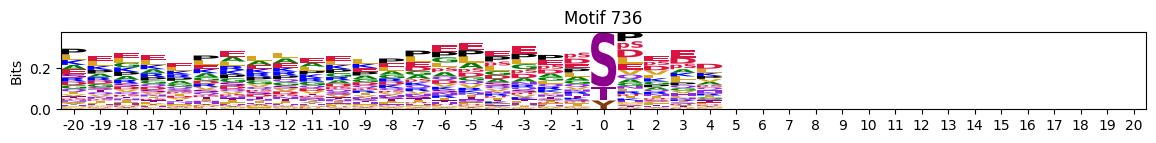

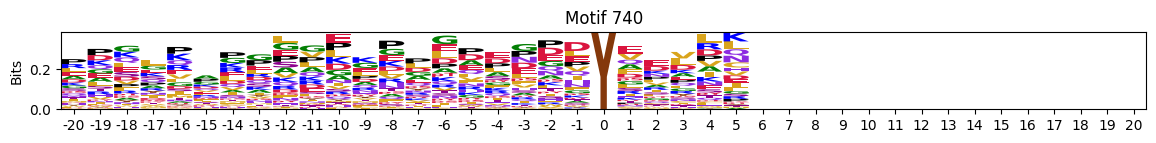

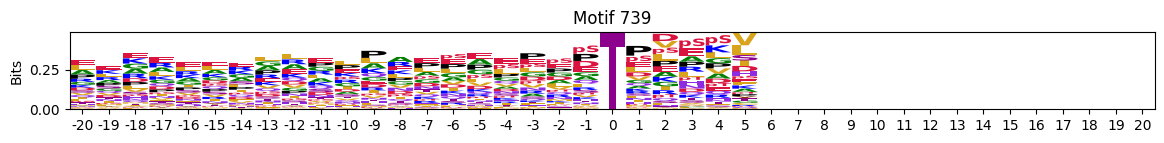

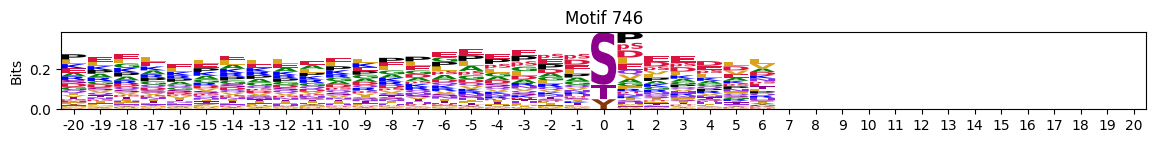

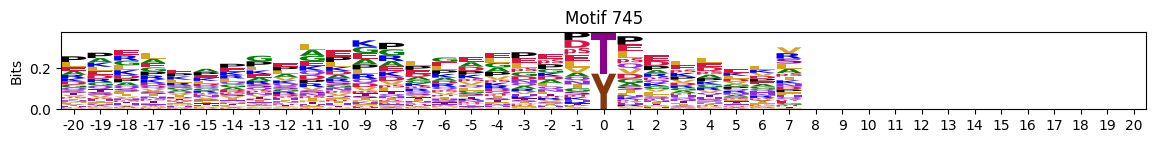

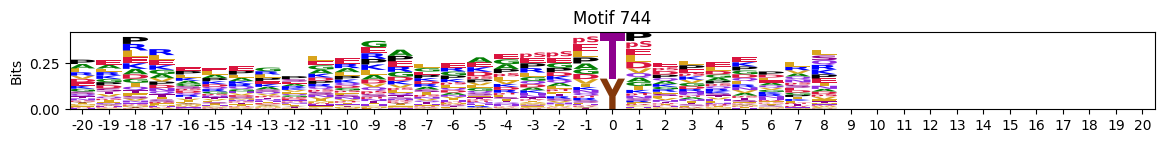

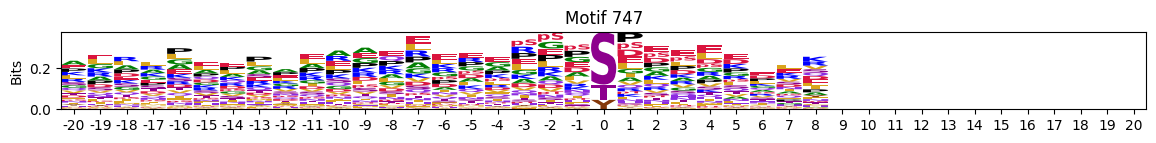

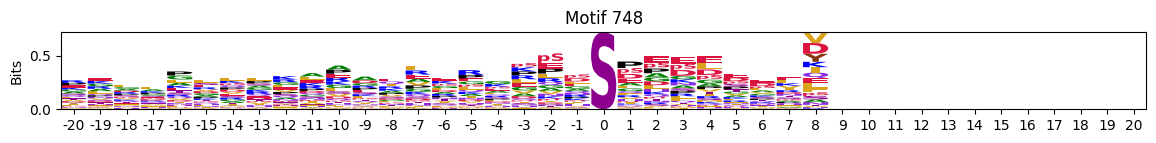

In [ ]:
plot_logos(pssms2,*idxs)

N-Terminal motifs:

In [ ]:
zeros = pssms2.apply(lambda r: (recover_pssm(r).sum()==0).sum() , axis=1)

In [ ]:
idxs = zeros.sort_values(ascending=False).head(10).index

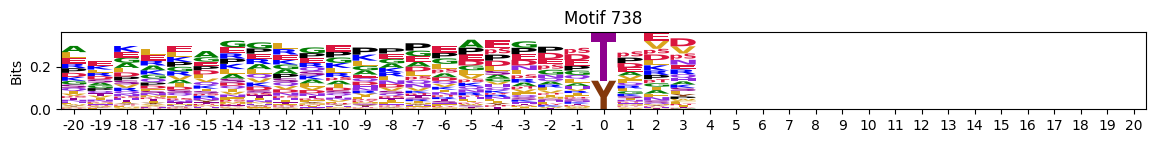

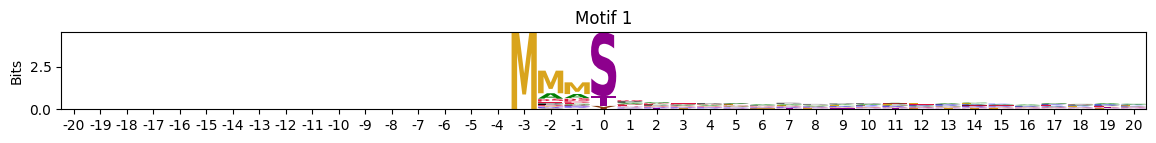

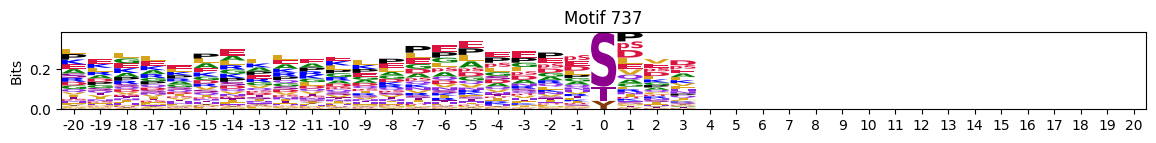

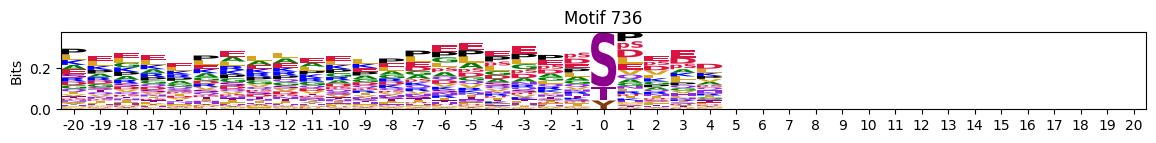

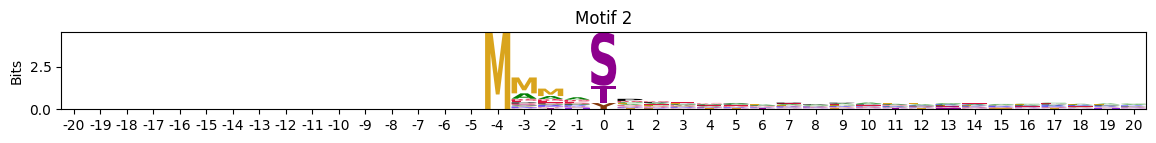

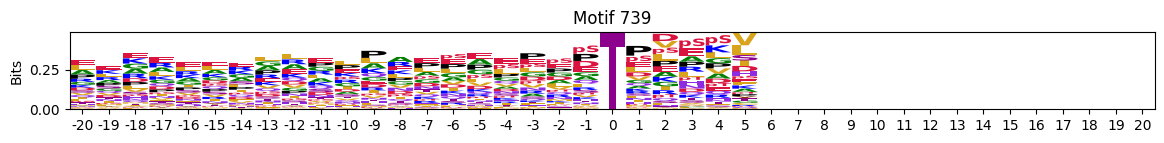

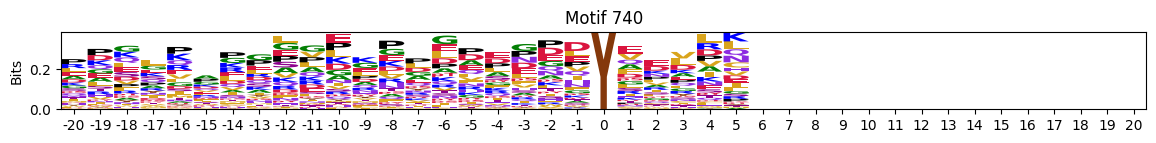

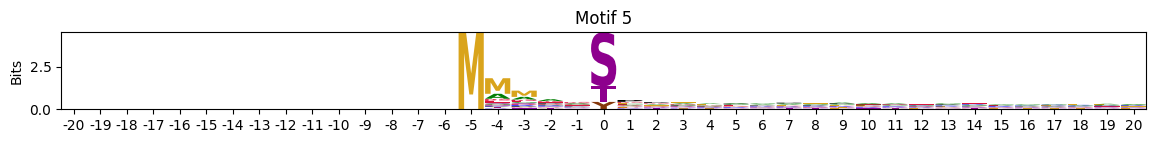

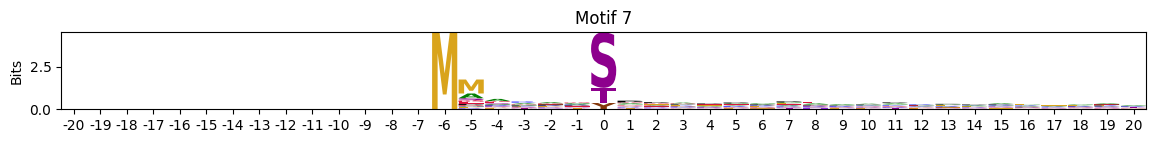

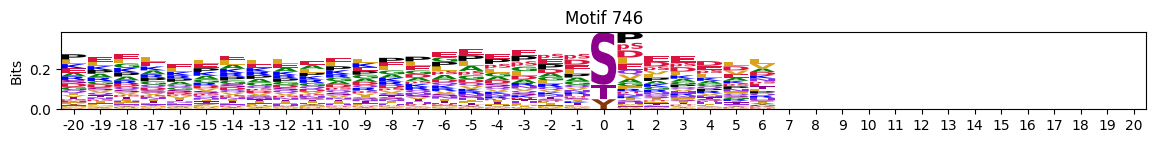

In [ ]:
plot_logos(pssms2,*idxs)

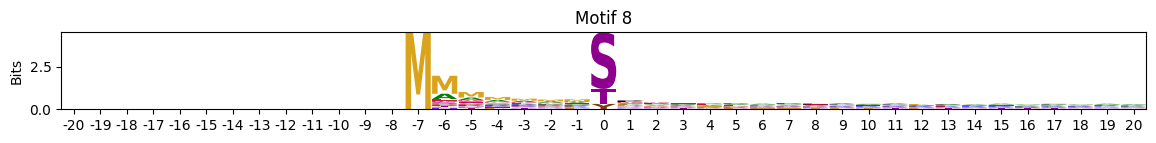

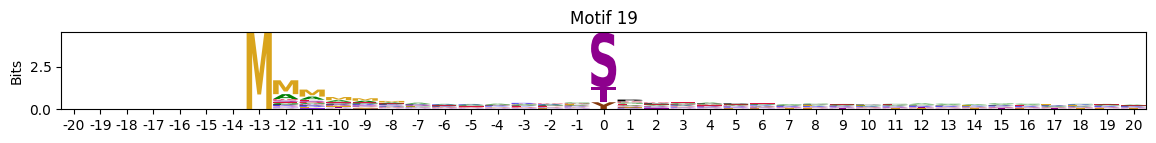

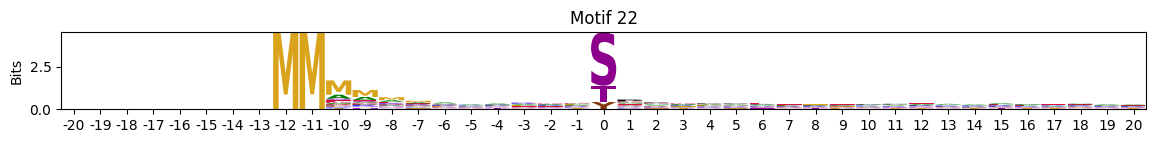

In [ ]:
plot_logos(pssms2,8,19,22)

## Umap

In [ ]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
annot = pd.DataFrame(all_site_pivot.index)

In [ ]:
annot = annot.merge(all_site[['sub_site','site','site_seq','substrate_genes']])

In [ ]:
sty = pd.get_dummies(annot['site'].str[0]).astype(int)

In [ ]:
sty = sty.set_index(all_site_pivot.index)

In [ ]:
all_site_pivot_sty = pd.concat([all_site_pivot,sty],axis=1)

In [ ]:
all_site_pivot_sty.head()

1  2  3  4  5  6  7  8  9  10  ...  740  741  742  743  744  \
sub_site                                       ...                            
A0A024R4G9_S20  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
A0A075B6Q4_S24  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
A0A075B6Q4_S35  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
A0A075B6Q4_S57  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
A0A075B6Q4_S68  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   

                745  746  S  T  Y  
sub_site                           
A0A024R4G9_S20    0    0  1  0  0  
A0A075B6Q4_S24    0    0  1  0  0  
A0A075B6Q4_S35    0    0  1  0  0  
A0A075B6Q4_S57    0    0  1  0  0  
A0A075B6Q4_S68    0    0  1  0  0  

[5 rows x 749 columns]

In [ ]:
reducer = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='jaccard',
    # min_dist=0.1,
    # random_state=42,
    # verbose=True,
)
embedding = reducer.fit_transform(all_site_pivot_sty)

f:\git\katlas\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
f:\git\katlas\.venv\lib\site-packages\logomaker/..\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


In [ ]:
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

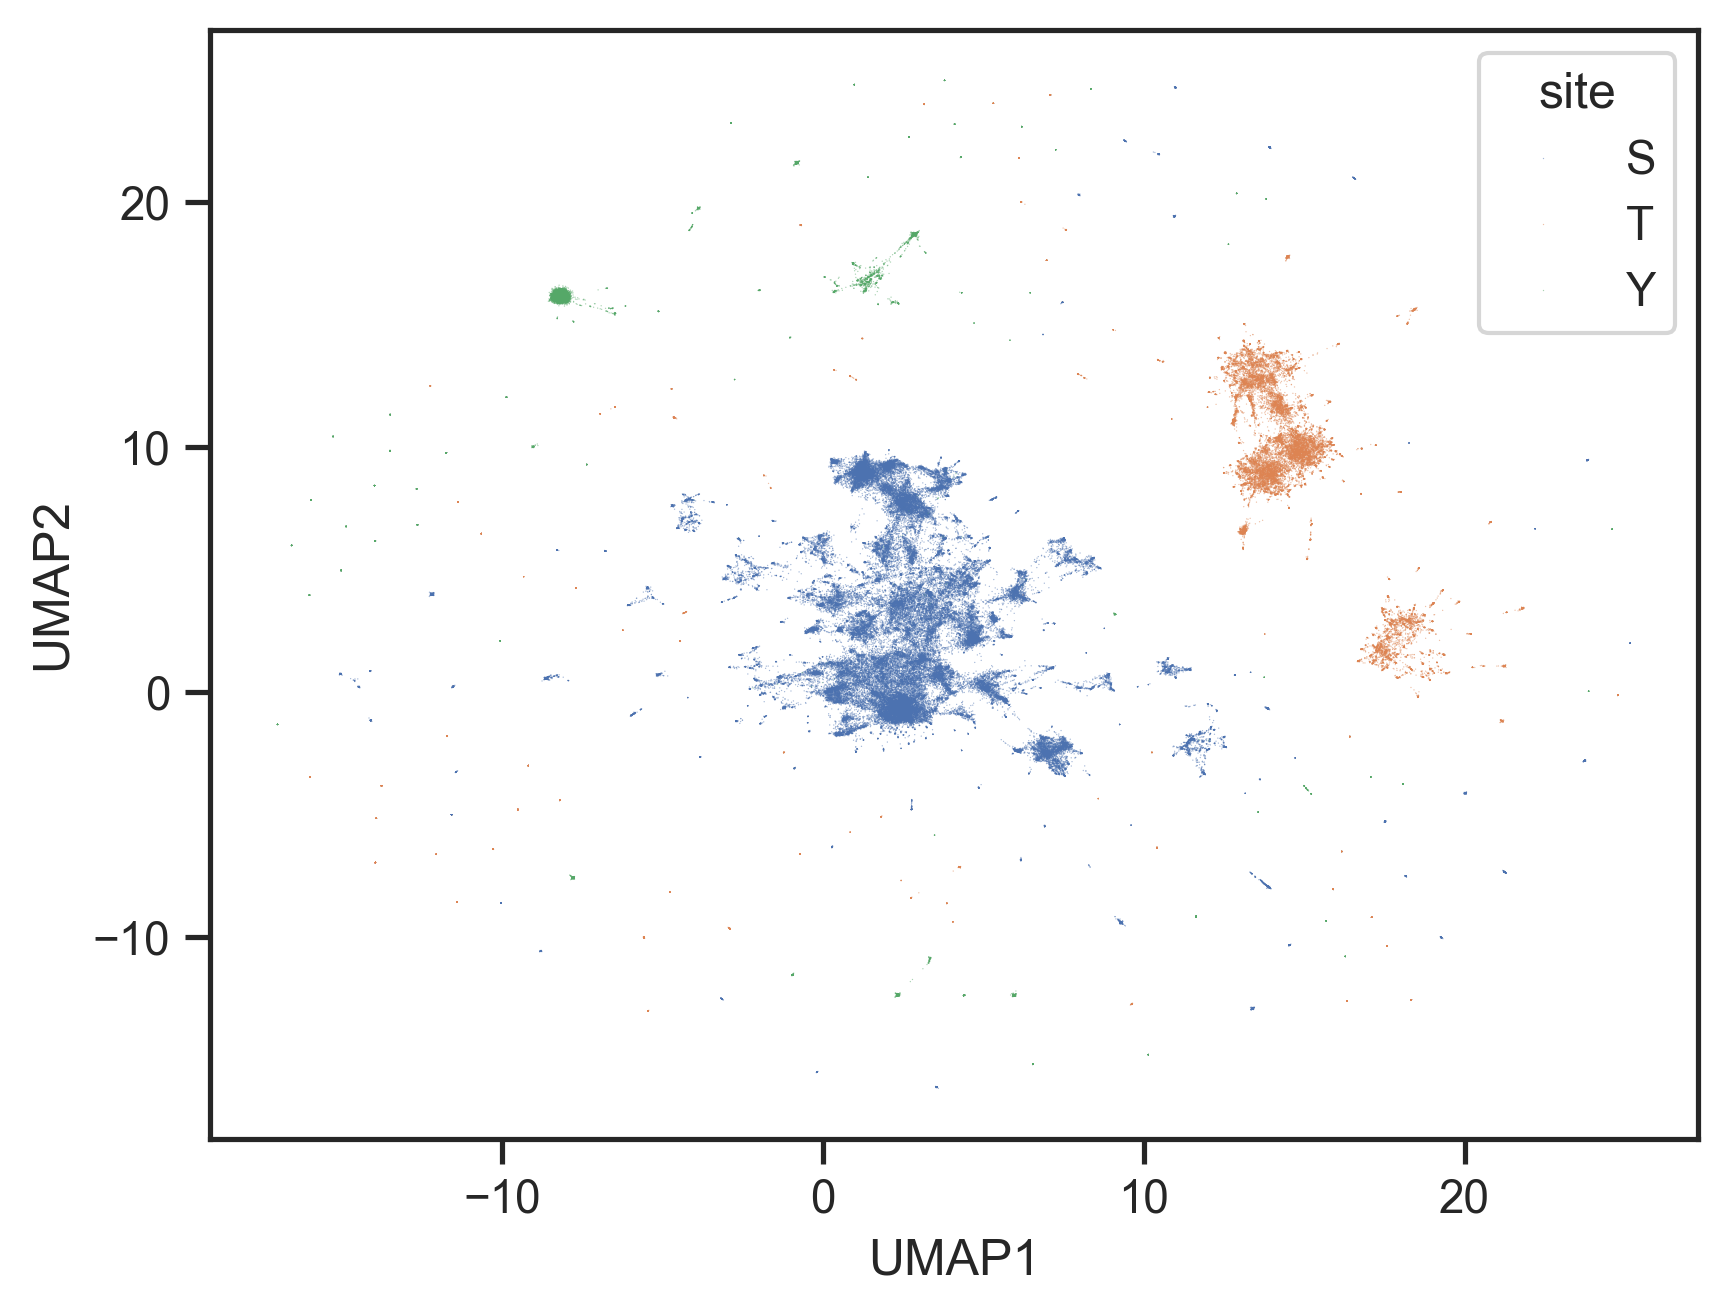

In [ ]:
sns.scatterplot(data=embedding_df, x='UMAP1', y='UMAP2', alpha=0.5,
                s=0.1,
                edgecolor='none',hue=annot['site'].str[0])

In [ ]:
annot['site_seq'].str.len()//2

0         20
1         20
2         20
3         20
4         20
          ..
131838    20
131839    20
131840    20
131841    20
131842    20
Name: site_seq, Length: 131843, dtype: int64

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

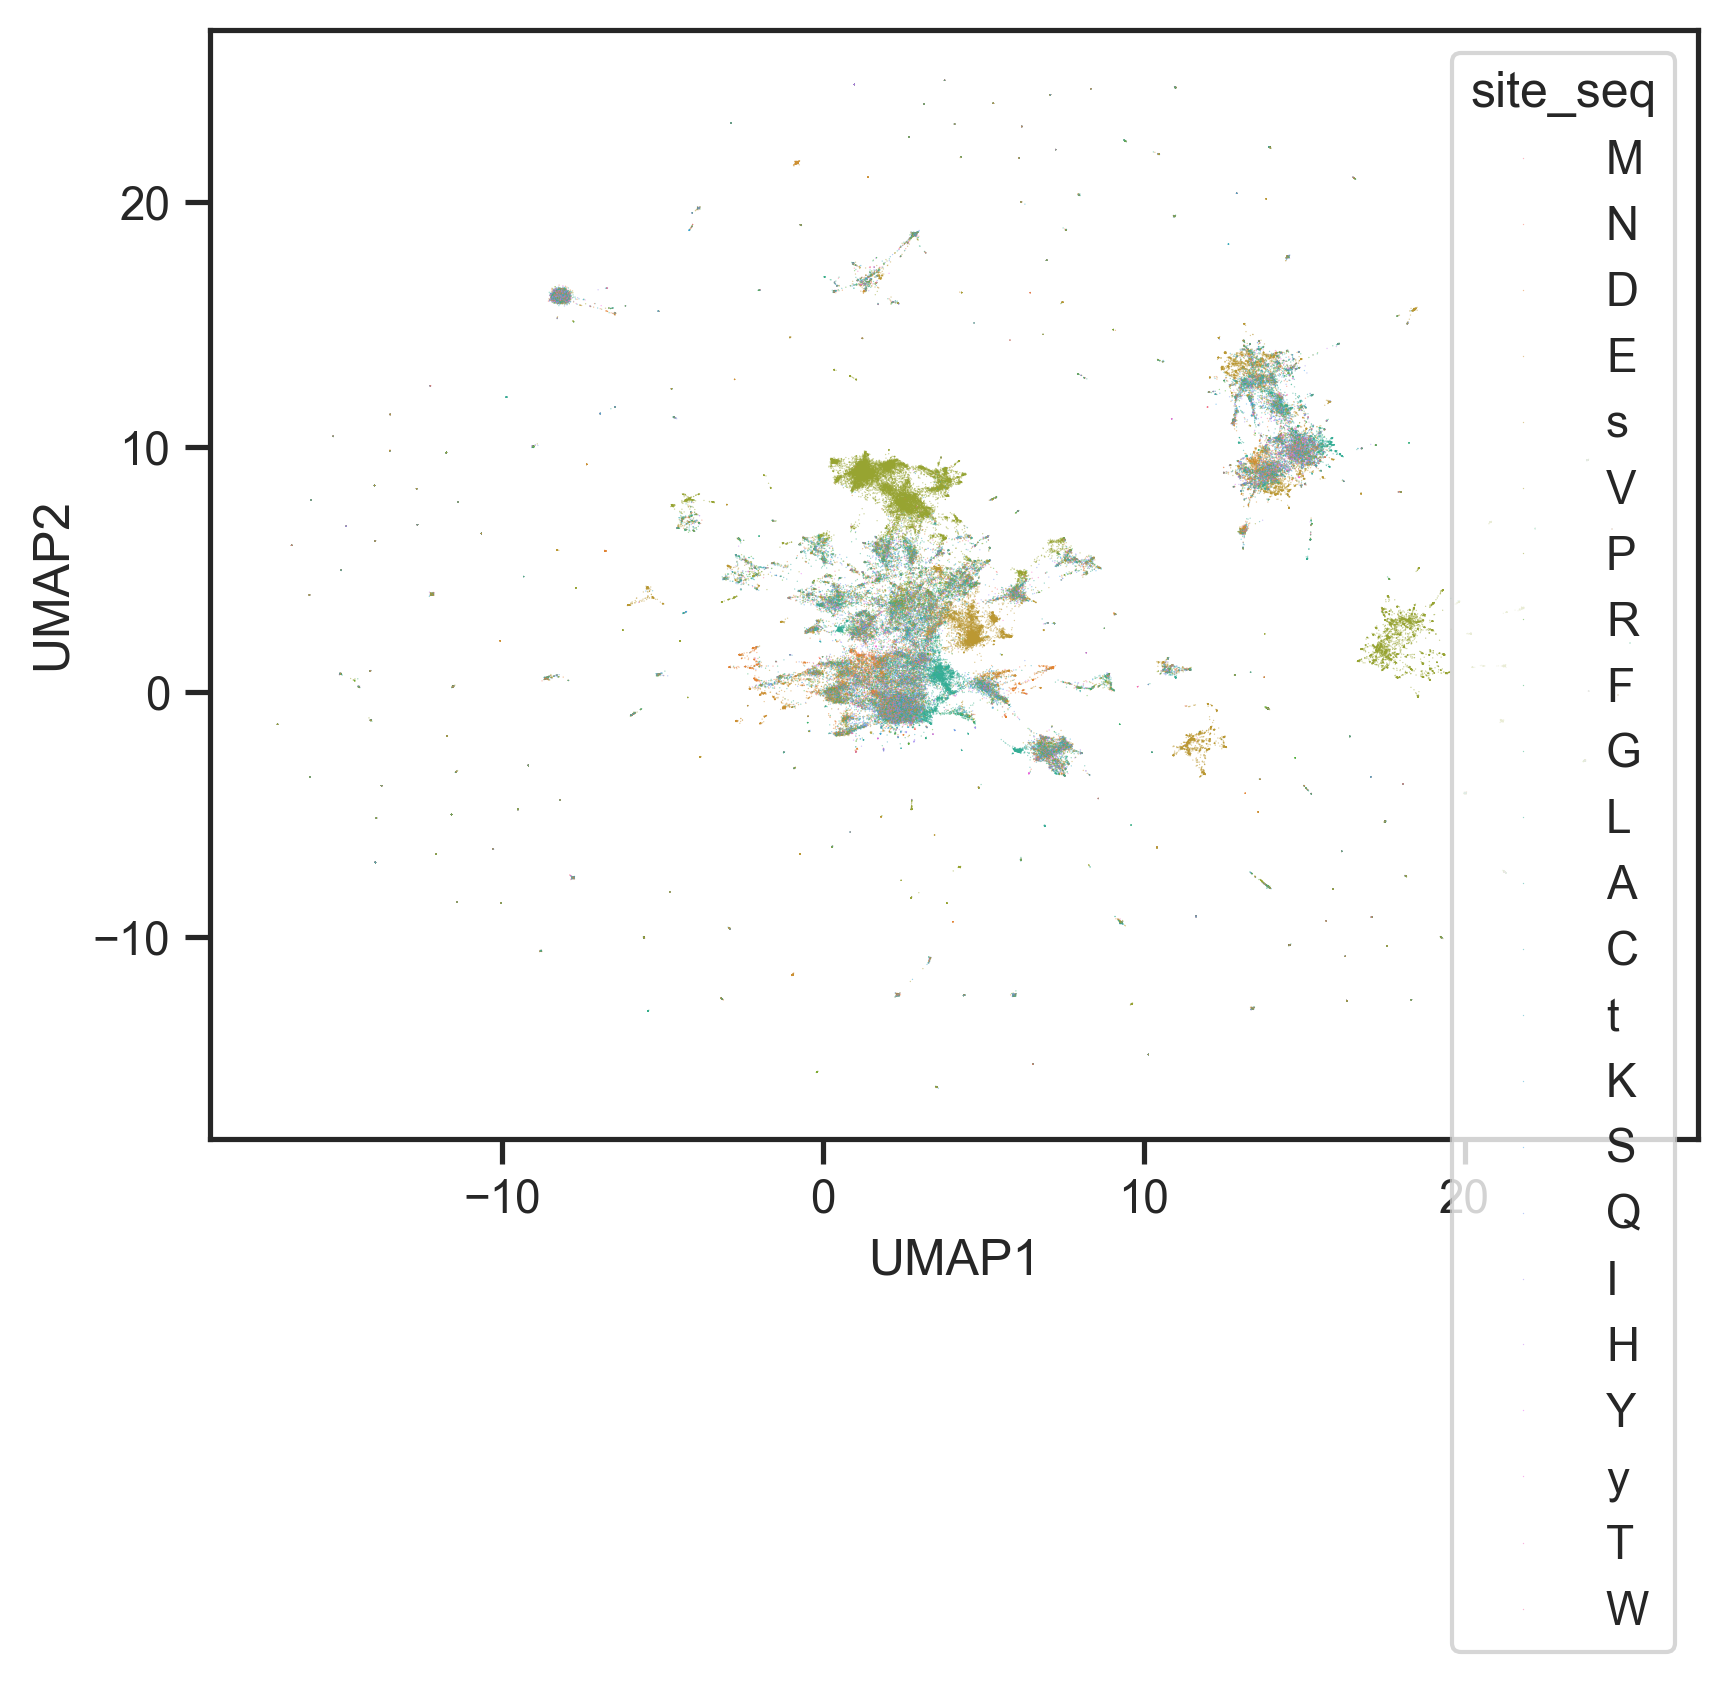

In [ ]:
sns.scatterplot(data=embedding_df, x='UMAP1', y='UMAP2', alpha=0.5,
                s=0.1,
                edgecolor='none',hue=annot['site_seq'].str[21])

## Entropy

In [ ]:
from katlas.core import *

In [ ]:
pspa = Data.get_pspa_all_norm()

In [ ]:
pspa.index.duplicated(keep=False).sum()

np.int64(0)

In [ ]:
pspa = pspa.dropna(axis=1) 

In [ ]:
entropy??

Signature: entropy(pssm_df, return_min=False, exclude_zero=False, contain_sty=True)
Source:   
def entropy(pssm_df,# a dataframe of pssm wtih index as aa and column as position
            return_min=False, # return min entropy as a single value or return all entropy as a series
            exclude_zero=False, # exclude the column of 0 (center position) in the entropy calculation
            contain_sty=True, # keep only s,t,y values (last three) in center 0 position
            ): 
    "Calculate entropy per position (max) of a PSSM surrounding 0"
    pssm_df = pssm_df.copy()
    pssm_df.columns= pssm_df.columns.astype(int)
    if 0 in pssm_df.columns:
        if exclude_zero:
            pssm_df = pssm_df.drop(columns=[0])
        if contain_sty:                       
            pssm_df.loc[pssm_df.index[:-3], 0] = 0
    pssm_df = pssm_df/pssm_df.sum()
    per_position = -np.sum(pssm_df * np.log2(pssm_df + 1e-9), axis=0)
    return per_position.min() if return_min else per_position

In [ ]:
entropy_flat??

Signature:
entropy_flat(
    flat_pssm: pandas.core.series.Series,
    return_min=False,
    exclude_zero=False,
    contain_sty=True,
)
Source:   
def entropy_flat(flat_pssm:pd.Series,return_min=False,exclude_zero=False,contain_sty=True): 
    "Calculate entropy per position of a flat PSSM surrounding 0"
    pssm_df = recover_pssm(flat_pssm)
    return entropy(pssm_df,return_min=return_min,exclude_zero=exclude_zero,contain_sty=contain_sty)
File:      f:\git\katlas\katlas\core.py
Type:      function

In [ ]:
entropies = []
ICs = []
for i,r in pspa.iterrows():
    entropies.append(entropy_flat(r,return_min=False).to_dict())
    ICs.append(get_IC_flat(r).to_dict())

In [ ]:
entropy_df = pd.DataFrame(entropies,index=pspa.index)
IC_df = pd.DataFrame(ICs,index=pspa.index)

In [ ]:
entropy_df

-5        -4        -3        -2        -1             0  \
kinase                                                                     
AAK1      4.238872  4.477492  4.419067  4.334337  4.285531  4.430518e-01   
ACVR2A    4.492276  4.483099  4.422408  3.851257  4.450203  9.999489e-01   
ACVR2B    4.480671  4.478871  4.409857  3.939154  4.426689  9.996887e-01   
AKT1      4.427160  4.402988  3.143867  3.590452  4.374148  9.659053e-01   
AKT2      4.427318  4.415247  2.970578  3.821267  4.416441  9.566125e-01   
...            ...       ...       ...       ...       ...           ...   
KDR       4.491261  4.472633  4.457427  4.448105  4.381677 -1.442695e-09   
FLT4      4.511274  4.501896  4.500559  4.504176  4.297943 -1.442695e-09   
WEE1_TYR  4.507984  4.495537  4.489914  4.470009  4.089527 -1.442695e-09   
YES1      4.497127  4.491665  4.442265  4.465032  4.274232 -1.442695e-09   
ZAP70     4.355980  4.260120  4.111361  4.128756  3.473012 -1.442695e-09   

                 1         2         3         4  
kinase                                            
AAK1      2.367128  4.484580  4.459749  4.448665  
ACVR2A    4.101970  4.509378  4.502156  4.509964  
ACVR2B    4.074009  4.491815  4.508044  4.505800  
AKT1      4.334536  4.429082  4.442455  4.412808  
AKT2      4.467609  4.463490  4.452789  4.435681  
...            ...       ...       ...       ...  
KDR       4.390681  4.443358  4.152800  4.462793  
FLT4      4.290937  4.344806  4.154417  4.498858  
WEE1_TYR  4.284853  4.403815  4.301392  4.426540  
YES1      4.350331  4.485518  4.275385  4.492019  
ZAP70     3.634941  4.358286  4.286572  4.474739  

[396 rows x 10 columns]

In [ ]:
# columns surrounding 0
cols = pspa.columns[~pspa.columns.str.startswith('0')]

In [ ]:
pspa[cols].max(1).sort_values()

kinase
VRK2         0.0941
ROS1         0.0983
TYK2         0.0995
LIMK1_TYR    0.1027
RET          0.1027
              ...  
YANK2        3.7589
GSK3B        3.9147
YANK3        4.2045
CK1A         5.8890
CK1G3        8.4920
Length: 396, dtype: float64

In [ ]:
def plot_dots(df,ylabel='bits',figsize=(5,3)):
    df.columns = df.columns.astype(str)
    plt.figure(figsize=figsize)
    for i, col in enumerate(df.columns):
        x_jitter = np.random.normal(loc=i, scale=0.1, size=len(df))
        plt.scatter(x_jitter, df[col], alpha=0.7, s=5,edgecolors='none')

    plt.xticks(range(len(df.columns)), df.columns)
    plt.xlabel("Position")
    plt.ylabel(ylabel)

In [ ]:
def plot_violin(df, ylabel='bits', figsize=(5, 3)):
    df_melted = df.melt(var_name='Position', value_name='Value')
    plt.figure(figsize=figsize)

    sns.violinplot(x='Position', y='Value', data=df_melted, inner=None, density_norm='width')
    sns.stripplot(x='Position', y='Value', data=df_melted, color='k', size=2, jitter=True, alpha=0.5)

    plt.xlabel('Position')
    plt.ylabel(ylabel)
    plt.tight_layout()

In [ ]:
plot_violin(entropy_df,ylabel='Entropy (bits)')
plt.title('Entropy per Position');

plot_violin(IC_df,ylabel='Information content (bits)')
plt.title('Information Content per Position');

In [ ]:
plot_dots(IC_df,ylabel='Information Content (bits)')
plt.title('Information Content per Position');

plot_dots(entropy_df,ylabel='Entropy (bits)')
plt.title('Entropy per Position');

In [ ]:
entropy_df.columns

Index(['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4'], dtype='object')

In [ ]:
entropy_df2 = entropy_df.drop(columns=['0']).copy()

In [ ]:
entropy_df2.min(1).sort_values().head(20)

kinase
CK1G3     1.674890
CK1A      1.825040
YANK3     1.943948
YANK2     2.017911
P38G      2.053687
P38D      2.060065
GSK3B     2.067587
GSK3A     2.108316
CDK17     2.123790
CK1G2     2.148218
CDK3      2.198466
SBK       2.216507
CK1A2     2.221651
ERK7      2.223145
CK1D      2.236495
CDK16     2.255882
AAK1      2.367128
FAM20C    2.400912
CDK18     2.435806
CDK4      2.452885
dtype: float64